<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/auto_quantum_circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet tensorflow_quantum

In [2]:
import cirq
import sympy
import tensorflow
import numpy
import gc

%matplotlib inline
import matplotlib.pyplot

from cirq.contrib.svg import SVGCircuit

import tensorflow_quantum

In [3]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [28]:
def create_quantum_model(gridSize, hyperGate):

    # cirq
    data_qubits = cirq.GridQubit.rect(gridSize, gridSize)
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    # create qubit
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # add layers
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, hyperGate, "zz1")
    # builder.add_layer(circuit, cirq.ZZ, "zz1")
    # builder.add_layer(circuit, cirq.CZ, "cz1")    

    # prepare the readout qubit
    circuit.append(cirq.H(readout))

    print(SVGCircuit(circuit))

    return circuit, cirq.Z(readout)

In [5]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., numpy.newaxis]/255.0, x_test[..., numpy.newaxis]/255.0

In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [7]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [8]:
x_train_small = tensorflow.image.resize(x_train, (4,4)).numpy()
x_test_small = tensorflow.image.resize(x_test, (4,4)).numpy()

In [9]:
x_train_nocon, y_train_nocon = x_train_small[:100], y_train[:100]

In [10]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [11]:
THRESHOLD = 0.5

x_train_bin = numpy.array(x_train_nocon > THRESHOLD, dtype=numpy.float32)
x_test_bin = numpy.array(x_test_small > THRESHOLD, dtype=numpy.float32)

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = numpy.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [13]:
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)

In [14]:
def hinge_accuracy(y_true, y_pred):
    y_true = tensorflow.squeeze(y_true) > 0.0
    y_pred = tensorflow.squeeze(y_pred) > 0.0
    result = tensorflow.cast(y_true == y_pred, tensorflow.float32)

    return tensorflow.reduce_mean(result)

In [15]:
x_train_tfcirc = tensorflow_quantum.convert_to_tensor(x_train_circ)
x_test_tfcirc = tensorflow_quantum.convert_to_tensor(x_test_circ)

In [16]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [17]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [18]:
class GarbageCollectorCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [19]:

gc.collect() 

233

In [30]:
for gate in [cirq.XX, cirq.ZZ]:
  for gridSize_int in [2, 3]:

    gc.collect() 

    model_circuit, model_readout = create_quantum_model(gridSize_int, gate)
    SVGCircuit(model_circuit)

    # Build the Keras model.
    model = tensorflow.keras.Sequential([
        # The input is the data-circuit, encoded as a tf.string
        tensorflow.keras.layers.Input(shape=(), dtype=tensorflow.string),
        # tensorflow.keras.layers.Dense(64, activation='relu'),
        # The PQC layer returns the expected value of the readout gate, range [-1,1].
        tensorflow_quantum.layers.PQC(model_circuit, model_readout),])

    model.compile(
      loss=tensorflow.keras.losses.mse,
      #loss=tensorflow.keras.losses.Hinge(),
      optimizer=tensorflow.keras.optimizers.SGD(),
      #optimizer=tensorflow.keras.optimizers.Adam(),
      # metrics=[hinge_accuracy]
      #metrics=[hinge_accuracy]
      )
    
    print(model.summary())

    qnn_history = model.fit(
        x_train_tfcirc_sub, y_train_hinge_sub,
        batch_size=32,
        epochs=EPOCHS,
        verbose=1,
        callbacks=[GarbageCollectorCallback()],
        validation_data=(x_test_tfcirc, y_test_hinge))

    qnn_results = model.evaluate(x_test_tfcirc, y_test)
    

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_10 (PQC)                (None, 1)                 8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4/4 [==============================] - 3s 654ms/step - loss: 1.9200 - val_loss: 2.0508
Epoch 2/3
4/4 [==============================] - 3s 833ms/step - loss: 1.7600 - val_loss: 2.0508
Epoch 3/3
62/62 [==============================] - 2s 26ms/step - loss: 1.8364
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_11 (PQC)                (None, 1)                 18        
                                                                 
Total params: 18
Train

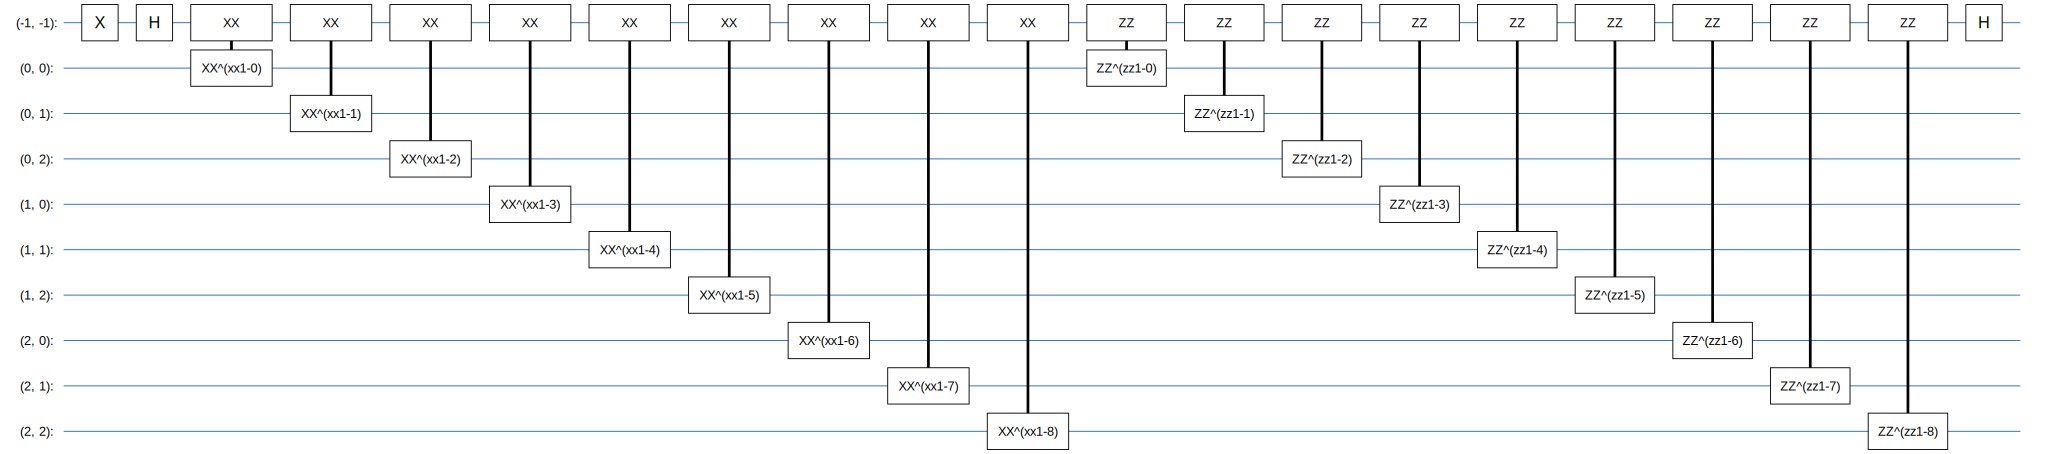

In [31]:
SVGCircuit(model_circuit)